In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("Data.csv")

In [4]:
import numpy as np
import pandas as pd

# ===== 1. Polynomial & Interaction Features =====
df['AT^2'] = df['AT'] ** 2
df['V^2'] = df['V'] ** 2
df['AP^2'] = df['AP'] ** 2
df['RH^2'] = df['RH'] ** 2

# Pairwise interactions
df['AT_V'] = df['AT'] * df['V'] # GT-ST interaction
df['AT_AP'] = df['AT'] * df['AP']
df['AT_RH'] = df['AT'] * df['RH']
df['V_AP'] = df['V'] * df['AP']
df['V_RH'] = df['V'] * df['RH']
df['AP_RH'] = df['AP'] * df['RH']

# Composite feature representing overall turbine influence
df['GT_ST_Index'] = (df['AT'] * df['RH']) / (df['V'] + 1)  # Avoid division by zero

# ===== 2. Temperature Features =====
df['AT_diff_mean'] = df['AT'] - df['AT'].mean()
df['AT_norm'] = (df['AT'] - df['AT'].min()) / (df['AT'].max() - df['AT'].min())

# Heat Index (per NOAA formula)
df['HI'] = (-42.379 + 2.04901523 * df['AT'] + 10.14333127 * df['RH'] -
            0.22475541 * df['AT'] * df['RH'] - 0.00683783 * df['AT']**2 -
            0.05481717 * df['RH']**2 + 0.00122874 * df['AT']**2 * df['RH'] +
            0.00085282 * df['AT'] * df['RH']**2 - 0.00000199 * df['AT']**2 * df['RH']**2)

# ===== 3. Pressure & Humidity Features =====
df['AP_diff_mean'] = df['AP'] - df['AP'].mean()
df['RH_diff_mean'] = df['RH'] - df['RH'].mean()

# Dew Point (in °C)
df['Dew_Point'] = df['AT'] - (100 - df['RH']) / 5

# Vapor Pressure
df['P_vapor'] = df['RH'] * 6.11 * np.exp((17.27 * df['AT']) / (df['AT'] + 237.3)) / 100

# Humidity Ratio
df['Humidity_Ratio'] = (0.622 * df['P_vapor']) / (df['AP'] - df['P_vapor'])

# Cooling Power Index: useful for thermal efficiency estimation
df['Cooling_Power_Index'] = (df['AT'] - df['AP']) * df['RH']

# Vapor Pressure Deficit
df['VPD'] = (1 - df['RH'] / 100) * df['P_vapor']

# Rolling stats (3-hour window)
df['AT_roll_mean'] = df['AT'].rolling(window=3).mean()
df['V_roll_std'] = df['V'].rolling(window=3).std()
df['AP_roll_min'] = df['AP'].rolling(window=3).min()
df['RH_roll_max'] = df['RH'].rolling(window=3).max()

# ===== 5. Categorical Engineering =====
df['Temp_Category'] = pd.cut(df['AT'], bins=[0, 10, 25, 40], labels=['Cold', 'Moderate', 'Hot'])
df['Humidity_Category'] = pd.cut(df['RH'], bins=[0, 40, 70, 100], labels=['Dry', 'Normal', 'Humid'])

# ===== Final Cleanup =====
df.drop(columns=['P_vapor'], inplace=True)  # Already used in other features

In [5]:
df.dropna(inplace=True)

In [6]:
X = df.drop(columns="PE", axis=1)
Y = df.PE

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.30, random_state = 1)

In [8]:
print('X_train shape : ({0},{1})'.format(X_train.shape[0], X_train.shape[1]))
print('y_train shape : ({0},)'.format(y_train.shape[0]))
print('X_test shape : ({0},{1})'.format(X_test.shape[0], X_test.shape[1]))
print('y_test shape : ({0},)'.format(y_test.shape[0]))

X_train shape : (6629,30)
y_train shape : (6629,)
X_test shape : (2841,30)
y_test shape : (2841,)


PE_Class
Low            2369
Medium-High    2369
Medium-Low     2366
High           2366
Name: count, dtype: int64


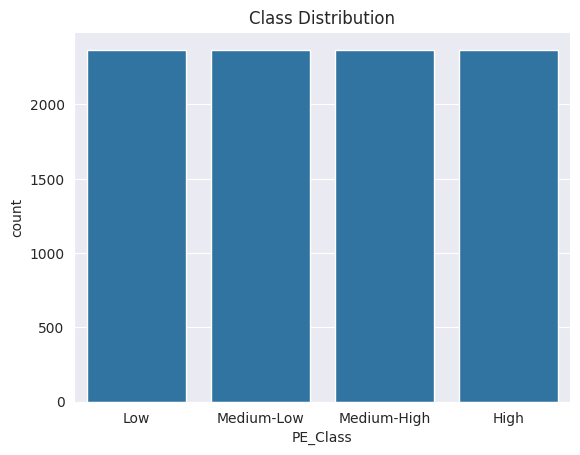

In [9]:
# Bin PE into 4 balanced classes
bins = pd.qcut(df['PE'], q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
df['PE_Class'] = bins

# Check balance
print(df['PE_Class'].value_counts())
sns.countplot(data=df, x='PE_Class')
plt.title("Class Distribution")
plt.show()


In [10]:
# Create qcut with return of bin intervals
bins_with_ranges = pd.qcut(df['PE'], q=4)

# Extract the unique intervals used for the cut
print("Bin Intervals:")
print(bins_with_ranges.unique())


Bin Intervals:
[(468.4, 495.76], (439.71, 451.455], (451.455, 468.4], (420.259, 439.71]]
Categories (4, interval[float64, right]): [(420.259, 439.71] < (439.71, 451.455] < (451.455, 468.4] < (468.4, 495.76]]


In [11]:
# Core features
base_features = ['AT', 'V', 'AP', 'RH']

# Polynomial features
poly_features = ['AT^2', 'V^2', 'AP^2', 'RH^2']

# Interaction & composite features (includes GT-ST effect)
interaction_features = ['AT_V', 'AT_AP', 'AT_RH', 'V_AP', 'V_RH', 'AP_RH', 'GT_ST_Index']


# Environmental/physical indices
env_indices = ['Cooling_Power_Index', 'VPD', 'HI', 'Dew_Point', 'Humidity_Ratio']

# Combine them into 5 sets for model comparison
feature_sets = {
    "Base": base_features,
    "Poly": base_features + poly_features,
    "Interaction": base_features + interaction_features,
    "All+Env": base_features + poly_features + interaction_features + env_indices
}


In [12]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9470 entries, 2 to 9526
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   AT                   9470 non-null   float64 
 1   V                    9470 non-null   float64 
 2   AP                   9470 non-null   float64 
 3   RH                   9470 non-null   float64 
 4   AT^2                 9470 non-null   float64 
 5   V^2                  9470 non-null   float64 
 6   AP^2                 9470 non-null   float64 
 7   RH^2                 9470 non-null   float64 
 8   AT_V                 9470 non-null   float64 
 9   AT_AP                9470 non-null   float64 
 10  AT_RH                9470 non-null   float64 
 11  V_AP                 9470 non-null   float64 
 12  V_RH                 9470 non-null   float64 
 13  AP_RH                9470 non-null   float64 
 14  GT_ST_Index          9470 non-null   float64 
 15  AT_diff_mean         9470 

In [13]:
results = []

for name, features in feature_sets.items():
    X = df[features]
    y = df['PE_Class']

    # Drop any remaining NaNs from lag or rolling features
    X = X.dropna()
    y = y.loc[X.index]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

    # Setup model with GridSearch
    dt = DecisionTreeClassifier()
    param_grid = {
        'max_depth': [3, 5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'criterion': ['gini', 'entropy']
    }

    clf = GridSearchCV(dt, param_grid, cv=20, scoring='accuracy')
    clf.fit(X_train, y_train)

    best_model = clf.best_estimator_
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"\nModel: {name}")
    print("Best Params:", clf.best_params_)
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred))

    # Save result
    results.append({
        "Model": name,
        "Best Params": clf.best_params_,
        "Accuracy": round(acc * 100, 2)
    })



Model: Base
Best Params: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}
Accuracy: 0.8187258007743752
              precision    recall  f1-score   support

        High       0.85      0.90      0.87       710
         Low       0.83      0.88      0.86       711
 Medium-High       0.81      0.75      0.78       710
  Medium-Low       0.78      0.75      0.76       710

    accuracy                           0.82      2841
   macro avg       0.82      0.82      0.82      2841
weighted avg       0.82      0.82      0.82      2841


Model: Poly
Best Params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 10}
Accuracy: 0.8254135867652235
              precision    recall  f1-score   support

        High       0.90      0.87      0.88       710
         Low       0.85      0.86      0.85       711
 Medium-High       0.80      0.80      0.80       710
  Medium-Low       0.76      0.78      0.77       710

    accuracy                           0.83      2841

In [14]:
results_df = pd.DataFrame(results)
results_df

,Model,Best Params,Accuracy
0,Base,"{'criterion': 'entropy', 'max_depth': 10, 'min...",81.87
1,Poly,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",82.54
2,Interaction,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",82.72
3,All+Env,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",83.42
